In [ ]:
###################### Magic commands

##%%timeit -n 1 -r 1
#%%time
import time
#start = time.time()

###################### at the end

#end = time.time()
#print(end - start)

###################### Packages

import numpy as np
import numpy.random as npr
import pandas as pd
#import Pyarrow # for pandas
import scipy.special
import math 
import numba
import matplotlib.pyplot as plt
from scipy.stats import linregress
from fctpls.utils import stooq_txt_to_df, stooq_to_notebook_format

# we load stooq data (with
# pip install fbm
# from fbm import FBM

###################### Options

npr.seed(0)
import warnings
warnings.filterwarnings('ignore')

#<
#>

############### Tools transfering numpy to numba

@numba.njit(parallel=True, fastmath=False) 
def np_apply_along_axis_2darray(func1d, axis, arr):
  assert arr.ndim == 2
  assert axis in [0, 1]
  if axis == 0:
    result = np.empty(arr.shape[1])
    for i in numba.prange(len(result)):
      result[i] = func1d(arr[:, i])
  else:
    result = np.empty(arr.shape[0])
    for i in numba.prange(len(result)):
      result[i] = func1d(arr[i, :])
  return result

@numba.njit(parallel=True, fastmath=False) 
def np_mean_2darray(array, axis):
  return np_apply_along_axis_2darray(np.mean, axis, array)

@numba.njit(parallel=True, fastmath=False) 
def np_std_2darray(array, axis):
  return np_apply_along_axis_2darray(np.std, axis, array)

################################################## Non-empty

def check_cond(gamma,c,tau,q):
    if 0<tau:
        if gamma<1 and 0<gamma and 2<q and 0<c and 2*(c+tau)*gamma<1 and q*(1-2*tau*gamma)>2 and q*c*gamma>1 and tau <1/(2*gamma):
            print('Valid!')
        else:
            print('Not valid!')
    else:
        if gamma<1 and 0<gamma and 2<q and 0<c and 2*(c+tau)*gamma<1 and q*c*gamma>1:
            print('Valid!')
        else:
            print('Not valid!')        
    return

def check_cond_no_q(gamma,c,tau):
    if gamma<1 and 0<gamma and 0<c and 2*(c+tau)*gamma<1:
        print('Valid!')
    else:
        print('Not valid!')   
    return

@numba.njit(parallel=True, fastmath=True)
def find_cond_all(h_gamma,h_c,h_tau,h_q,max_c,max_tau,max_q):
    gamma_mesh = np.linspace(0.01,0.99,h_gamma)
    c_mesh = np.linspace(0.1,max_c,h_c)
    tau_mesh = np.linspace(-max_tau,max_tau,h_tau)
    q_mesh = np.linspace(2.1,max_q,h_q)
    for gamma_index in numba.prange(h_gamma):
        for c_index in numba.prange(h_c): 
            for tau_index in numba.prange(h_tau):
                for q_index in numba.prange(h_q):
                    gamma=gamma_mesh[gamma_index]
                    c=c_mesh[c_index]
                    tau=tau_mesh[tau_index]
                    q=q_mesh[q_index]
                    if 0<tau:
                        if 2<q and 0<c and 2*(c+tau)*gamma<1 and q*(1-2*tau*gamma)>2 and q*c*gamma>1:
                            print([gamma, c, tau, q])
                    else:
                        if 2<q and 0<c and 2*(c+tau)*gamma<1 and q*c*gamma>1:
                            print([gamma, c, tau, q])                        
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_no_q(grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    c_mesh = np.arange(1,10)
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for c_index in numba.prange(c_mesh.shape[0]): 
            for tau_index in numba.prange(tau_mesh.shape[0]):
                gamma=gamma_mesh[gamma_index]
                c=c_mesh[c_index]
                tau=tau_mesh[tau_index]
                if 2*(c+tau)*gamma<1:
                    print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_gamma_no_q(grid_gamma,c,tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        gamma=gamma_mesh[gamma_index]
        if 2*(c+tau)*gamma<1:
            print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_c_no_q(c,grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for tau_index in numba.prange(tau_mesh.shape[0]):
            gamma=gamma_mesh[gamma_index]
            tau=tau_mesh[tau_index]
            if 2*(c+tau)*gamma<1:
                print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_c_tau_no_q(c,tau,grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for tau_index in numba.prange(tau_mesh.shape[0]):
            gamma=gamma_mesh[gamma_index]
            tau=tau_mesh[tau_index]
            if 2*(c+tau)*gamma<1:
                print([gamma, c, tau])
    return 'Done!'

################################################## Generating Data

@numba.njit(parallel=False, fastmath=False)
def Lomax_quantile_function(x,theta,s):  
    return s*((1-x)**(-1/theta)-1)

@numba.njit(parallel=True, fastmath=False)
def Pareto_quantile_function(x,gamma,s): # support is  {x \ge s} and theta=1/\gamma
    return s*(1-x)**(-gamma)

#The Burr distribution has survival distribution $\bar{F}(y)=(1+y^\rho)^{-\theta} \in 2\RV_{-\theta \rho,-\rho}$ where $x\ge 0$ and $\theta,\rho>0$.
@numba.njit(parallel=True, fastmath=False) # rho,theta positive
def Burr_quantile_function(x,theta,rho): 
    return ((1-x)**(-1/theta)-1)**(1/rho)

@numba.njit(parallel=True, fastmath=False)
def beta_func3(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.exp(-grid**2+grid)**2)/d)
    return np.exp(-grid**2+grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func2(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.exp(-grid)**2)/d)
    return np.exp(-grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func5(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(1/(1/12+grid**2))/d))
    return np.sin(1/(1/12+grid**2))/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func6(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.cos(2*np.pi*grid+np.sin(1/(grid+1/10)))/d))
    return np.cos(2*np.pi*grid+np.sin(1/(grid+1/10)))/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func7(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.cos(2*np.pi*grid)**2)/d)
    return np.cos(2*np.pi*grid)/norm


@numba.njit(parallel=True, fastmath=False)
def beta_func4(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_1D(d,H,sigma):
    H2 = 2 * H
    matcov = np.zeros((d-1,d-1))
    for i in numba.prange(d-1):
        for j in numba.prange(i,d-1):
            r = (sigma**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
            r = r/(d**H2)
            matcov[i, j] = r
            matcov[j, i] = matcov[i, j]
    L = np.linalg.cholesky(matcov)
    Z = npr.normal(0,1,size=(d - 1))
    fBm = np.dot(L , Z)
    #out=np.concatenate(([0], fBm))
    # out=np.hstack(([0], fBm))
    out= np.asarray([0] + list(fBm))
    return out

# @Article{RePEc:jss:jstsof:v:005:i07,
#  author={Coeurjolly, Jean-Francois},
#  title={{Simulation and identification of the fractional Brownian motion: a bibliographical and comparative study}},
#  journal={Journal of Statistical Software},
#  year=2000,
#  volume={5},
#  number={i07},
#  pages={},
#  month={},
#  keywords={},
#  doi={http://hdl.handle.net/10.18637/jss.v005.i07}
#}

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_array(Z,H,sigma): # Z=npr.normal(0,1,size=(N,n,d - 1))
    N=Z.shape[0]
    n=Z.shape[1]
    d=Z.shape[2]+1
    out = np.zeros((N,n,d))
    for p in numba.prange(N):
        for q in numba.prange(n):    
            H2 = 2 * H
            matcov = np.zeros((d-1,d-1))
            for i in numba.prange(d-1):
                for j in numba.prange(i,d-1):
                    r = (sigma**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
                    r = r/(d**H2)
                    matcov[i, j] = r
                    matcov[j, i] = matcov[i, j]
            L = np.linalg.cholesky(matcov)
            fBm = np.dot(L , Z[p,q,:])
            #out=np.concatenate(([0], fBm))
            # out=np.hstack(([0], fBm))
            out[p,q,:]= np.asarray([0] + list(fBm))
    return out

@numba.njit(parallel=True, fastmath=False)
def sigma(u,c,snr): 
    return (u**c)/snr

@numba.njit(parallel=True, fastmath=False)
def noise_mean(d,mu):
    grid=np.linspace(0,1,d)
    return mu*grid

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu): #Z = npr.normal(0,1,size=(N,n,d - 1))  
                                     #Y = Pareto_iterated_sample(N,n,theta,s)
    N=Y.shape[0]
    n=Y.shape[1]
    d=Z.shape[2]+1
    out = np.zeros((N,n,d))
    H2 = 2 * H
    matcov = np.zeros((d-1,d-1))
    for p in numba.prange(N):
        for q in numba.prange(n):
            matcov = np.zeros((d-1,d-1))
            for i in numba.prange(d-1):
                for j in numba.prange(i,d-1):
                    r = (sigma(Y[p,q],c,snr)**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
                    r = r/(d**H2)
                    matcov[i, j] = r
                    matcov[j, i] = matcov[i, j]
            L = np.linalg.cholesky(matcov)
            fBm = np.dot(L , Z[p,q,:])
            out[p,q,:]= np.asarray([0]+list(fBm)) + noise_mean(d,mu)
    return out

################################################## Estimation

@numba.njit(parallel=True, fastmath=False) 
def esdf(data,x): # Empirical Survival Distribution Function of Y. Here, x.shape = (N,) or (N,n) is the threshold
    # data is Y and data.shape = (N,n)
    N=data.shape[0]
    n=data.shape[1]
    if x.ndim == 1:
        indicator_matrix = np.transpose(np.where(np.transpose(data)>x,1,0)) # binary matrix with same shape as data representating the indicator matrix 1_{X_ij<x_j}
    if x.ndim == 2:
        indicator_matrix = np.where(data>x,1,0)
    return np.sum(indicator_matrix,axis=1)/n # (N,)
    
@numba.njit(parallel=True, fastmath=False)
def threshold_index(X,Y,Y_sort_index,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    out=np.zeros((N,))
    aux=concomittant_corr(X,Y,Y_sort_index,tau,m)[:,start:]
    return start+np.argmax(aux,axis=1)
    
@numba.njit(parallel=True, fastmath=False)
def threshold(X,Y,Y_sort_index,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    y_matrix_out = np.zeros((N,n))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    index = threshold_index(X,Y,Y_sort_index,tau,m,start)
    for i in numba.prange(N):
        y_matrix_out[i,:] = Y_sort[i,n-index[i]-1]*np.ones((n,))
    return y_matrix_out

@numba.njit(parallel=True, fastmath=False) 
def fepls_weight(Y,y_matrix,nu): # Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # nu is such that \psi(x) = x^nu
    N=Y.shape[0]
    n=Y.shape[1]
    out=np.zeros((N,))
    aux = Y**nu # size (N,n) - \psi(Y_i)
    aux2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \psi(Y_i)*1_{Y_i \ge y}
    return np.sum(aux2,axis=1)/n # size (N,)

#@numba.njit(parallel=True, fastmath=False) # It seems that "greater_equal" and numba don't work well together
def fepls(X,Y,y_matrix,tau): # X of size (N,n,d) and Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # tau is the tail index of \vfi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in range(d):
        aux = np.multiply(X[:,:,j],Y**tau) # size (N,n,d) - Product \vfi(Y_i)*X_i
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \vfi(Y_i)*X_i*1_{Y_i \ge y}
        out[:,j]= np.sum(out2,axis=1)/n # (N,d)
    norms=np.sqrt(np.sum(out**2,axis=1)/d) # length (N,)
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 # size (N,d)

@numba.njit(parallel=True, fastmath=False) 
def fepls_numba(X,Y,y_matrix,tau): # X of size (N,n,d) and Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # tau is the tail index of \vfi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in numba.prange(d):
        aux = np.multiply(X[:,:,j],Y**tau) # size (N,n,d) - Product \vfi(Y_i)*X_i
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \vfi(Y_i)*X_i*1_{Y_i \ge y}
        out[:,j]= np.sum(out2,axis=1)/n # (N,d)
    norms=np.sqrt(np.sum(out**2,axis=1)/d) # length (N,)
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 # size (N,d)

# g(t)= t^c with c \in \{1/4,1/2,1,3/2\} 
# X = g(Y)\beta + \eps

@numba.njit(parallel=True, fastmath=False) 
def Hill(Y,int_seq): # Y of size (N,n), y number, int_seq is an intermediate sequence, ie such that int_seq << n
    N=Y.shape[0]
    n=Y.shape[1]
    Y_ord=np.copy(Y)
    Y_ord=np.sort(Y_ord) 
    Y_2=Y_ord[:,n-int_seq-1]
    aux=Y_ord/Y_2[:, None]
    out=np.log(aux[:,0:n-int_seq])
    return (1/int_seq)*np.sum(out,axis=1) # size (N,)

#### Same as np.sort for 2D arrays but works with numba njit+parallel
@numba.njit(parallel=True, fastmath=False) 
def sort_2d_array(x):
    n,m=np.shape(x)
    for row in numba.prange(n):
        x[row]=np.sort(x[row])
    return x

@numba.njit(parallel=True, fastmath=False) 
def hatbeta_dot_beta(X,Y,tau,l):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    y_array=np.zeros((N,n,np.arange(int(n/l)).size))
    out=np.zeros((N,np.arange(int(n/l)).size))
    YY=np.copy(Y)
    for p in numba.prange(int(n/l)):
        y_array[:,0,p]=sort_2d_array(YY)[:,n-l*p-1]
        for k in numba.prange(N):
            y_array[k,:,p]=y_array[k,0,p]
        hat_beta=fepls_numba(X,Y,y_array[:,:,p],tau) 
        out[:,p]=(1/d)*np.sum(np.multiply(hat_beta,X[:,p,:]),axis=1) 
    return out

@numba.njit(parallel=True, fastmath=False) 
def concomittant_corr(X,Y,Y_sort_index,tau,m): # 1\le m \le n # Y_sort_index = np.argsort(Y,axis=1)
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((N,m))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    for k in numba.prange(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((N,k+1))
        aux2 = np.zeros((N,k+1))
        aux3 = Y_sort[:,n-k-1:] # shape (N,k+1)
        aux3_sum = np.sum(aux3,axis=1)
        for i in numba.prange(k):
            y_array[:,0,i] = Y_sort[:,n-i-1]
            for j_2 in numba.prange(N):
                y_array[j_2,:,i] = y_array[j_2,0,i]
            hat_beta = fepls_numba(X,Y,y_array[:,:,i],tau) 
            for j_1 in numba.prange(N):
                i_c = Y_sort_index[j_1,i]
                aux[j_1,i]=(1/d)*np.sum(np.multiply(hat_beta[j_1,:],X[j_1,i_c,:]))
                aux2[j_1,i]= np.multiply(aux[j_1,i],Y_sort[j_1,n-i-1]) 
                out[j_1,k]= np.corrcoef(aux3[j_1,:],aux[j_1,:])[0,1]
    return out
    
def bitcoin_concomittant_corr(X,Y,tau,m): # 1\le m \le n 
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((m))
    Y_sort=np.sort(Y,axis=1)
    Y_sort_index = np.argsort(Y,axis=1)
    for k in range(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((k+1))
        aux2 = np.zeros((k+1))
        aux3 = Y_sort[0,n-k-1:] # shape (k+1)
        aux3_sum = np.sum(aux3)
        for i in range(k):
            y_array[:,:,i] = (Y_sort[0,n-i-1])*np.ones((1,n))
            hat_beta = fepls(X,Y,y_array[:,:,i],tau) 
            i_c = Y_sort_index[0,i]
            aux[i]=(1/d)*np.sum(np.multiply(hat_beta[0,:],X[0,i_c,:]))
            aux2[i]= np.multiply(aux[i],Y_sort[0,n-i-1]) 
            out[k]= np.corrcoef(aux3,aux)[0,1]
    return np.abs(out)

def bitcoin_threshold_index(X,Y,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    out = np.zeros((N,n))
    return start+np.argmax(bitcoin_concomittant_corr(X,Y,tau,int(n/5))[start:])
    
def bitcoin_threshold(X,Y,tau,m,start):# 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    out = np.zeros((N,n))
    Y_sort_index = np.argsort(Y,axis=1)
    Y_sort=np.sort(Y,axis=1)
    index = bitcoin_threshold_index(X,Y,tau,m,start)
    out[0,:] = Y_sort[0,n-index-1]
    return out

@numba.njit(parallel=True, fastmath=False) 
def hatbeta_dot_X(X,hat_beta): # hat_beta=fepls(X,Y,y_matrix,tau) of shape (N,d)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
            out[:,i]=(1/d)*np.sum(np.multiply(hat_beta,X[:,i,:]),axis=1) 
    return out

@numba.njit(parallel=True, fastmath=False) # the same as np.dot(X,beta_func(d))/d (which is preferable)
def beta_dot_X(X):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func(d)),axis=1) 
    return out
    
@numba.njit(parallel=True, fastmath=False) # np.dot(X,beta_func(d))/d
def beta_dot_X(X,beta_param):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
        if beta_param == 1:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func(d)),axis=1)
        elif beta_param == 2:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func2(d)),axis=1)
        elif beta_param == 3:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func3(d)),axis=1)
        elif beta_param == 4:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func4(d)),axis=1)
    return out
    
@numba.njit(parallel=True, fastmath=False) 
def conditional_cov_Y_hat_beta_X(X,Y,hat_beta,y_matrix,tau): #hat_beta = fepls(X,Y,y_matrix,tau)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    A=hatbeta_dot_X(X,hat_beta)
    cov_A=np.zeros((N,))
    cov_B=np.zeros((N,))
    for k in numba.prange(N):
        cov_A[k] = (((A[k,:])[Y[k,:]>y_matrix[k,:]])*((Y[k,:])[Y[k,:]>y_matrix[k,:]])).mean() - ((A[k,:])[Y[k,:]>y_matrix[k,:]]).mean()*((Y[k,:])[Y[k,:]>y_matrix[k,:]]).mean()
    return cov_A

#@numba.njit(parallel=True, fastmath=False) # does not work with numba (no idea why)
def conditional_cov_Y_beta_X(X,Y,y):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    B=beta_dot_X(X)
    cov_B=np.zeros((N,))
    for k in numba.prange(N):
        cov_B[k] = (((B[k,:])[Y[k,:]>y])*((Y[k,:])[Y[k,:]>y])).mean()-((B[k,:])[Y[k,:]>y]).mean()*((Y[k,:])[Y[k,:]>y]).mean()
    return cov_B

def Exponential_QQ_Plot_1D(Y,k):
    n=Y.shape[1]
    out=np.zeros((k))
    out2=np.zeros((k))
    YY=np.sort(Y,axis=1)
    for i in range(k):
        out[i]=np.log((k+1)/(i+1))
        out2[i]=  np.log(YY[0,n-i-1])-np.log(YY[0,-k])
    return np.column_stack((out,out2))

################################################## Conditional quantile estimation (2D+3D array)
################# Application: Bitcoin/SP500 quantile

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_2D(x): # x is a np.array of shape (p,q);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        for j in numba.prange(x.shape[1]):
            if x[i,j]<=1 and x[i,j]>=0:
                out[i,j] = np.multiply(3/2,1-np.power(x[i,j],2))
            else:
                out[i,j]=0
    return out

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_1D(x): # x is a np.array of shape (p);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        if x[i]<=1 and x[i]>=0:
            out[i] = np.multiply(3/2,1-np.power(x[i],2))
        else:
            out[i]=0
    return out
    
@numba.njit(parallel=False, fastmath=False) 
def Gaussian_kernel(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*np.power(x,2))


@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight(X_dimred,x,h,kernel): # X_dimred of shape (N,n) just as Y 
    # e.g., X_dimred = hatbeta_dot_X(X,hat_beta) = F0
    # hat_beta=fepls(X,Y,y_matrix,tau)=E0; x real and h positive
    N=X_dimred.shape[0]
    n=X_dimred.shape[1]
    out=np.zeros((N,n))
    if kernel == 1:
        K_h=Epanechnikov_kernel_2D((X_dimred-x)/h) # shape (N,n)
    if kernel == 2:
        K_h=Gaussian_kernel((X_dimred-x)/h) # shape (N,n)
    return K_h/np.sum(K_h) ### shape = (N,n)

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_test_2D(X,Y,X_dimred,inner_prod,x_func,alpha,a,b,m,h,h_func,kernel): # X_dimred.shape = Y.shape = (N,n), e.g., X_dimred = hatbeta_dot_X(X,hat_beta) = F0
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]; h_func is positive
    # x_func_dot_beta.shape in \R; it represents the inner product between x_func (where we project for the plot) and the vector in H reducing the dimension
    # inner_prod.shape \in\R represents (x_func,beta)
    #  beta is reducing the dimension, i.e., X_dimred=(X,beta).
    # X_dimred = (X,beta); Y|X_dimred = x vs Y|X=x*x_func  
    out = np.zeros((m,2))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func,kernel) 
        weight1=univariate_Nadaraya_weight(X_dimred,x_grid[p]*inner_prod,h,kernel)[0,:]  
        out[p,0]=weighted_quantile(Y[0,:],weight1,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_2D(X_2D,dimred,x_func,x,h,type,kernel): # X of shape (n,d), Y of shape (n), dimred and x_func of shape (d,)
    # dimred of shape (d,) is e.g. beta_func(d) or (fepls(X,Y,y_matrix,tau))[0,:]
    # Y|(X,dimred)=(x_func,dimred) (type 1) vs Y|(X,dimred) = x (type 2)
    d=x_func.shape[0]
    if type == 1:
        if kernel == 1:
            K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-np.dot(x_func,dimred)/d)/h) # shape (n,)
        if kernel == 2:
            K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-np.dot(x_func,dimred)/d)/h) # shape (n,)
    if type == 2:     
        if kernel == 1:
            K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-x)/h) # shape (n,)
        if kernel == 2:
            K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-x)/h) # shape (n,)
    return K_h/np.sum(K_h) ### shape = (,n)

@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_2D(X_2D,x_func,h,kernel): # X.shape = (n,d); h is positive ; x_func \in H ie of shape (d,)
    d=x_func.shape[0]
    aux = (X_2D-x_func*np.ones(d))**2 # shape = (n,d)
    norm = np.sqrt((1/d)*np.sum(aux,axis=1)) # shape = (n,)
    if kernel == 1:
        K_h= Epanechnikov_kernel_1D(norm/h) # shape = (n,)
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h)## shape = (n,)
    return K_h/np.sum(K_h) ### shape = (n,)

@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_3D(X,dimred_2D,x_func,x,h,type,kernel): # X of shape (N,n,d), Y of shape (N,n), dimred_2D of shape (N,d)
    # x_func of shape (d,) is e.g. beta_func(d) or (fepls(X,Y,y_matrix,tau))[0,:]
    # x is a real number (e.g., x=x_grid[p] for p \leq m)
    # Y|(X,dimred)=(x_func,dimred) (type 1) vs Y|(X,dimred) = x (type 2)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    K_h = np.zeros((N,n))
    for i in numba.prange(N):
        if type == 1:
            if kernel == 1:
                K_h[i,:]=Epanechnikov_kernel_1D((np.dot(X[i,:,:],dimred_2D[i,:])/d-np.dot(x_func,dimred_2D[i,:])/d)/h) # shape (n,)
            if kernel == 2:
                K_h[i,:]=Gaussian_kernel((np.dot(X[i,:,:],dimred_2D[i,:])/d-np.dot(x_func,dimred_2D[i,:])/d)/h) # shape (n,)
        if type == 2:
            if kernel == 1:
                K_h[i,:]=Epanechnikov_kernel_1D((np.dot(X[i,:,:],dimred_2D[i,:])/d-x)/h) # shape (n,)   
            if kernel == 2:
                K_h[i,:]=Gaussian_kernel((np.dot(X[i,:,:],dimred_2D[i,:])/d-x)/h) # shape (n,)
    return np.transpose(np.transpose(K_h)/np.sum(K_h,axis=1)) ### shape = (N,n)

@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_3D(X,x_func,h_func_2D,kernel): # X.shape = (N,n,d); h_func_2D.shape = (N,n); x_func \in H ie of shape (d,)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    aux = np.zeros((N,n,d))
    for i in numba.prange(N):
        aux[i,:,:] = (X[i,:,:]-x_func*np.ones(d))**2
    norm = np.sqrt((1/d)*np.sum(aux,axis=2))
    if kernel == 1:
        K_h= Epanechnikov_kernel_2D(norm/h_func_2D)
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h_func_2D)      
    return np.transpose(np.transpose(K_h)/np.sum(K_h,axis=1)) ### shape = (N,n)

@numba.njit(parallel=True, fastmath=False)   
def weighted_quantile(data,weight,alpha):  # data.shape=weight.shape=(n,) 
    # alpha is the treshold in (0,1)
    sorter = np.argsort(data)
    data = data[sorter]
    weight = weight[sorter]
    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)
    return np.interp(alpha, weighted_quantiles, data)

@numba.njit(parallel=True, fastmath=False) 
def iterated_weq_2D(data_2D,weight,alpha): # same treshold for all marginals and iterations 
    # data.shape = (N,n); weight.shape=(N,n)
    N=data_2D.shape[0]
    n=data_2D.shape[1]
    out = np.zeros((N,))
    for k in numba.prange(N):
        out[k]=weighted_quantile(data_2D[k,:],weight[k,:],alpha)
    return out # shape = (N)

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_dimred_vs_func_2D(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h,h_func,kernel): # dimred1,2 and x_func of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    out = np.zeros((m,3))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        #weight_func=functional_Nadaraya_weight(X,x_grid[p]*x_func,h)[0,:]#functional_Nadaraya_weight_Bitcoin(X,x_grid[p]*x_func,h)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func,kernel)
        weight1=univariate_Nadaraya_weight_2D(X[0,:,:],dimred1,x_grid[p]*x_func,x_grid[p],h,1,kernel)
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred2,x_grid[p]*x_func,x_grid[p],h,2,kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight1,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,2]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_dimred_vs_func_2D_total(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h_vector,h_func_vector,kernel): # dimred1,2 and x_func of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
    # h_vector.shape = h_func_vector.shape = (m,)
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    out = np.zeros((m,3))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        #weight_func=functional_Nadaraya_weight(X,x_grid[p]*x_func,h)[0,:]#functional_Nadaraya_weight_Bitcoin(X,x_grid[p]*x_func,h)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func_vector[p],kernel)
        weight1=univariate_Nadaraya_weight_2D(X[0,:,:],dimred1,x_grid[p]*x_func,x_grid[p],h_vector[p],1,kernel)
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred2,x_grid[p]*x_func,x_grid[p],h_vector[p],2,kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight1,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,2]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False)
def plot_quantile_covariate_dimred_vs_func_3D(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h,h_func_2D,kernel): # dimred1,2 of shape (N,d), e.g., dimred = E = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
    # h_func_2D.shape = (N,n)
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    N=X.shape[0]
    out = np.zeros((N,m,3))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        weight_func=functional_Nadaraya_weight_3D(X,x_grid[p]*x_func,h_func_2D,kernel)
        weight1=univariate_Nadaraya_weight_3D(X,dimred1,x_grid[p]*x_func,x_grid[p],h,1,kernel)
        weight2=univariate_Nadaraya_weight_3D(X,dimred2,x_grid[p]*x_func,x_grid[p],h,2,kernel)
        out[:,p,0]=iterated_weq_2D(Y,weight1,alpha)
        out[:,p,1]=iterated_weq_2D(Y,weight2,alpha)
        out[:,p,2]=iterated_weq_2D(Y,weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_alpha_dimred_vs_func_3D(X,Y,dimred1,dimred2,x_func,x,a,b,m,h,h_func,type,kernel): # dimred of shape (N,d), e.g., dimred = E = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    N=X.shape[0]
    out = np.zeros((N,m,3))
    alpha_grid = np.linspace(0,1,m)
    for p in range(m):
        weight_func=functional_Nadaraya_weight_3D(X,x_func,h_func,kernel)
        weight1=univariate_Nadaraya_weight_3D(X,dimred1,x_func,x,h,1,kernel)
        weight2=univariate_Nadaraya_weight_3D(X,dimred2,x_func,x,h,2,kernel)
        out[:,p,0]=iterated_weq_2D(Y,weight1,alpha_grid[p])
        out[:,p,1]=iterated_weq_2D(Y,weight1,alpha_grid[p])
        out[:,p,2]=iterated_weq_2D(Y,weight_func,alpha_grid[p])
    return out

################################################## ][ Tail index  

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator(ordered_data):
    """
    Function to calculate Hill estimator array given an ordered data
    sequence. Decreasing ordering is required; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param ordered_data: numpy array of ordered data for which the 1st moment (Hill estimator) is calculated.
    :return: numpy array of Hill estimator corresponding to all possible order statistics of the dataset.
    """
    logs = np.log(ordered_data)
    logs_cumsum = np.cumsum(logs[:-1])
    k_vector = np.arange(1, len(ordered_data))
    m1 = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator_2D(ordered_data_2D): # ordered_data_2D = np.sort(-data,axis=1)*-1 with data 2D-array
    """
    Function to calculate Hill estimator array given an ordered data; e.g., ordered_data_2D = np.sort(-Y,axis=1)*-1
    sequence. Decreasing ordering is required; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param ordered_data: numpy array of ordered data for which the 1st moment (Hill estimator) is calculated.
    :return: numpy array of Hill estimator corresponding to all possible order statistics of the dataset.
    """
    N=ordered_data_2D.shape[0]
    n=ordered_data_2D.shape[1]
    m1=np.zeros((N,n-1))
    for i in numba.prange(N):
        logs = np.log(ordered_data_2D[i,:]) 
        logs_cumsum = np.cumsum(logs[:-1])
        k_vector = np.arange(1, len(ordered_data_2D[i,:]))
        m1[i,:] = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

@numba.njit(parallel=True, fastmath=False)
def Hill_estimator_one_value(ordered_data, k):
    """
    Function to calculate the Hill estimator for a specified order statistic k. Decreasing ordering is required.
    :param ordered_data: Decreasingly ordered sample; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param k: from 1 up to and including len(ordered_data) - 1
    :return: float with the value of the Hill estimator
    """
    selected_logs = np.log(ordered_data[:k+1])
    return 1./k * sum(selected_logs[:-1]) - selected_logs[-1]

@numba.njit(parallel=True, fastmath=False)
def Hill_estimator_one_value_2D(ordered_data_2D, k): # ordered_data_2D = np.sort(-data,axis=1)*-1 with data 2D-array
    N=ordered_data_2D.shape[0]
    n=ordered_data_2D.shape[1]
    out=np.zeros((N,))
    for i in numba.prange(N):
        selected_logs = np.log(ordered_data_2D[i,:k+1])
        out[i]=1./k * sum(selected_logs[:-1]) - selected_logs[-1]
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator(data,weight,alpha,J): 
    N=data.shape[0]
    d=data.shape[2]
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=iterated_weq(data,weight,alpha) # quantile_data2.shape=(N,d)
    out=np.zeros((N,))
    aux=np.zeros((N,J))
    for k in numba.prange(N):
        for j in numba.prange(J):
            quantile_data1=iterated_weq(data,weight,1-subdivision[j]*(1-alpha))
            aux[k,j] = np.log(quantile_data1[k,0])-np.log(quantile_data2[k,0])
            aux[k,j] /= -np.sum(np.log(subdivision))
        out[k] = np.sum(aux[k,:])
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator_2D(Y,weight,alpha,J):  # Y.shape= (N,n); weight.shape = (n,)
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=weighted_quantile(Y[0,:],weight,alpha) # 
    aux=np.zeros((J))
    for j in numba.prange(J):
        quantile_data1=weighted_quantile(Y[0,:],weight,1-subdivision[j]*(1-alpha))
        aux[j] = np.log(quantile_data1)-np.log(quantile_data2)
        aux[j] /= -np.sum(np.log(subdivision))
    return np.sum(aux)
    
@numba.njit(parallel=True, fastmath=False)  
def plot_tail_index_all_2D(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h,h_func,J,kernel): # Y.shape = (N,n); X.shape = (N,n,d); Y.shape = (n); x_func.shape = (d,); J=9
    # dimred1.shape = dimred2.shape = (d,)
    # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    x_grid=np.linspace(a,b,m)
    out=np.zeros((m,3))
    for p in numba.prange(m):
        weight1=univariate_Nadaraya_weight_2D(X[0,:,:],dimred1,x_grid[p]*x_func,x_grid[p],h,1,kernel)
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred2,x_grid[p]*x_func,x_grid[p],h,2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func,kernel)
        out[p,0]=tail_index_gamma_estimator_2D(Y,weight1,alpha,J)
        out[p,1]=tail_index_gamma_estimator_2D(Y,weight2,alpha,J)
        out[p,2]=tail_index_gamma_estimator_2D(Y,weight_func,alpha,J)
    return out

################################################## ][ Copula 

@numba.njit(parallel=True, fastmath=False) 
def marginal_wecdf(data,weight,x_vect): # x row vector of length d (each marginal has its own treshold)
    # e.g. for uniform treshold t, x_vect=x*np.ones((d,))
    # data.shape = (N,n,d); weight.shape=(N,n)
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,d))
    for k in numba.prange(N):
        for j in numba.prange(d):
            indicator_matrix = np.where(data[:,:,j]<x_vect[j],1,0) # binary matrix with same shape as data representating the indicator matrix 1_{X_ij<x_j}
            out[k,j]= np.sum(np.multiply(indicator_matrix[k,:],weight[k,:]))
    return out/n # (N,d)

@numba.njit(parallel=True, fastmath=False)
def rank(U): # U.shape = (N,n,d)
    R = np.empty_like(U)
    for p in numba.prange(U.shape[0]):
        for j in numba.prange(U.shape[2]):
            R[p,:, j] = np.argsort(np.argsort(U[p,:, j]))+1
    return R

@numba.njit(parallel=True, fastmath=False) 
def weighted_ranked_data(R,weight): # ie: \hat{F}_{j,n,y}(X_ij); R = rank(data) with shape (N,n,d); weight.shape=(N,n)
    N=R.shape[0]
    n=R.shape[1]
    d=R.shape[2]
    out=np.zeros((N,n,d))
    for k in numba.prange(N):
        for i in numba.prange(n):
            for j in numba.prange(d):
                r=np.int32(R[k,i,j])
                out[k,i,j]=np.sum(weight[k,0:r])
    return out/n 

@numba.njit(parallel=True, fastmath=False) 
def bivariate_indicator(data,j,k,x,y): # data.shape = (N,n,d); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    A=np.where(data[:,:,j]<x,1,0)
    B=np.where(data[:,:,k]<y,1,0)
    return np.multiply(A,B) # shape = (N,n)
    
@numba.njit(parallel=True, fastmath=False) 
def bivariate_anti_indicator(data,j,k,x,y): # data.shape = (N,n,d); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    A=np.where(data[:,:,j]<x,0,1)
    B=np.where(data[:,:,k]<y,0,1)
    return np.multiply(A,B) # shape = (N,n)
    
@numba.njit(parallel=True, fastmath=False) 
def bivariate_wecdf(data,weight,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_indicator(data,j_1,j_2,x,y)
    return np.sum(np.multiply(biv_indicator,weight),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_ecdf(data,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_indicator(data,j_1,j_2,x,y)
    return np.sum((biv_indicator),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_survival_wecdf(data,weight,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_anti_indicator(data,j_1,j_2,x,y)
    return np.sum(np.multiply(biv_indicator,weight),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def empirical_uniform_data(data,weight): 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out = np.zeros((N,n,d))
    for k in numba.prange(N):
        for i in numba.prange(n):
            out[k,i,:]=marginal_wecdf(data,weight,data[k,i,:])[k,:]
    return out

@numba.njit(parallel=True, fastmath=False) 
def weighted_empirical_copula(data,weight,j_1,j_2,u,v): # u.shape = (2,) in (0,1)
        # data.shape = (N,n,d); weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,n))
    data=empirical_uniform_data(data,weight)
    biv_indicator=bivariate_indicator(emp_unif_data,j_1,j_2,u,v)
    out= np.multiply(biv_indicator,weight)/n 
    return np.sum(out,axis=1) # return (N)-shape

@numba.njit(parallel=True, fastmath=False) 
def weighted_ranked_empirical_copula(weighted_ranked_data,weight,j_1,j_2,u,v): # u,v in (0,1)
        # weighted_ranked_data=weighted_ranked_data(R.astype(int),weight) where R=rank(data); 
        # weighted_ranked_data.shape = (N,n,d) is ; weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    N=weighted_ranked_data.shape[0]
    n=weighted_ranked_data.shape[1]
    d=weighted_ranked_data.shape[2]
    out=np.zeros((N,n))
    biv_indicator=bivariate_indicator(weighted_ranked_data,j_1,j_2,u,v)
    out= np.multiply(biv_indicator,weight)/n 
    return np.sum(out,axis=1) # return (N)-shape


In [ ]:
################################################## Execute (Synthetic Data)

N=500
n=500
d=101
s_Y=1 # scale parameter of Pareto/Lomax distribution
c= 1 # c is \kappa the tail index of g
tau=-2 # tail index of \vfi
#nu = 1 #  tail index of \psi such that 2\gamma \nu_j < 1 for all 1\le j \le J
snr=10 # signal-to-noise ratio
H=1/3 # Hurst parameter of fBm noise
gamma=1/3# 1/3 or 1/2 or 9/10
rho=-1/2
mu = 200 # noise mean
l=2 # grid parameter
start = 4

tic=time.time()

#Y=Pareto_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
#Y=Lomax_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)
Y_sim=Y

Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)
y_matrix = threshold(X,Y,Y_sort_index,tau,100,start)
E = fepls(X,Y,y_matrix,tau)
#E2 = fepls_numba(X,Y,y_matrix,tau) # Same but not parallelizable and slower...
#F=hatbeta_dot_X(X,E)

#############################################################################
print(check_cond_no_q(gamma,c,tau))
print("Time cost",time.time()-tic)
##################################################################################################

In [ ]:
################################## Plot Histograms (Synthetic Data)
N=500
n=500
d=101
s_Y=1 # scale parameter of Pareto/Lomax distribution
c= 2 # c is \kappa the tail index of g
tau=-2 # tail index of \vfi
#nu = 1 #  tail index of \psi such that 2\gamma \nu_j < 1 for all 1\le j \le J
snr=10 # signal-to-noise ratio
H=1/3 # Hurst parameter of fBm noise
gamma=9/10# 1/3 or 1/2 or 9/10
rho=-1/2
mu = 200 # noise mean
l=2 # grid parameter
start = 4

Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)
Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)
y_matrix = threshold_index(X,Y,Y_sort_index,tau,m,start)
plt.hist(y_matrix, bins=m)
plt.savefig('hist_k_10_2_0_9.pdf')  
plt.show()

c= 2 # c is \kappa the tail index of g
gamma=1/2
Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)
Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)
y_matrix = threshold_index(X,Y,Y_sort_index,tau,m,start)
plt.hist(y_matrix, bins=m)
plt.savefig('hist_k_10_2_0_5.pdf')  
plt.show()

c= 2 # c is \kappa the tail index of g
gamma=1/3
Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)
Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)
y_matrix = threshold_index(X,Y,Y_sort_index,tau,m,start)
plt.hist(y_matrix, bins=m)
plt.savefig('hist_k_10_2_0_333.pdf')  
plt.show()


In [ ]:
############################################################ Estim plot (Synthetic Data)

N=500
n=500
d=101
s_Y=1 # scale parameter of Pareto/Lomax distribution
c= 3/2 # c is \kappa the tail index of g
tau=-2 # tail index of \vfi
snr=10 # signal-to-noise ratio
H=1/3 # Hurst parameter of fBm noise
gamma=1/3# 1/3 or 1/2 or 9/10
rho=-1/2
mu = 200 # noise mean
start=4
l=2 # grid parameter
tic=time.time()

#Y=Pareto_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
#Y=Lomax_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)

Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)
y_matrix2 = threshold(X,Y,Y_sort_index,tau,100,0)
y_matrix3 = threshold(X,Y,Y_sort_index,tau,100,4)
y_matrix4 = threshold(X,Y,Y_sort_index,tau,100,9)

E2 = fepls(X,Y,y_matrix2,tau)
E3 = fepls(X,Y,y_matrix3,tau)
E4 = fepls(X,Y,y_matrix4,tau)

#############################################################################
print(check_cond_no_q(gamma,c,tau))
##################################################################################################

# Calculate the maximum and minimum values for each position
#max_values = np.max(E, axis=0) # shape (d,)
#min_values = np.min(E, axis=0) # shape (d,)
max_values2 = np.nanquantile(E2, 0.95, axis=0) # shape (d,)
min_values2 = np.nanquantile(E2, 0.05, axis=0) # shape (d,)
mean_values2 = np.nanmean(E2, axis=0) # shape (d,)
median_values2 = np.nanmedian(E2, axis=0) # shape (d,)

# Create x values (assuming x values are just indices in this case)
x_values = np.arange(d)

fig,ax = plt.subplots()

# Set x-axis tick labels to discretized interval [0,1]
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.set_xticklabels([0,0 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ])

# Plot the fill between the max and min values
ax.fill_between(x_values, min_values2, max_values2, color='skyblue', alpha=0.4)
ax.plot(x_values, mean_values2)
ax.plot(x_values, beta_func(d))

# Add labels and legend
#ax.xlabel('Index')
#ax.ylabel('Values')
#ax.title('FEPLS Estimation of beta - Confidence intervals')
#plt.legend()
# Show the plot
plt.savefig('beta_estim_plot_conc100_0_1_5_0_333.pdf')  
plt.show()

# Calculate the maximum and minimum values for each position
#max_values = np.max(E, axis=0) # shape (d,)
#min_values = np.min(E, axis=0) # shape (d,)
max_values3 = np.nanquantile(E3, 0.95, axis=0) # shape (d,)
min_values3 = np.nanquantile(E3, 0.05, axis=0) # shape (d,)
mean_values3 = np.nanmean(E3, axis=0) # shape (d,)
median_values3 = np.nanmedian(E3, axis=0) # shape (d,)

fig,ax = plt.subplots()

# Set x-axis tick labels to discretized interval [0,1]
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.set_xticklabels([0,0 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ])

# Plot the fill between the max and min values
ax.fill_between(x_values, min_values3, max_values3, color='skyblue', alpha=0.4)
ax.plot(x_values, mean_values3)
ax.plot(x_values, beta_func(d))

# Add labels and legend
#ax.xlabel('Index')
#ax.ylabel('Values')
#ax.title('FEPLS Estimation of beta - Confidence intervals')
#plt.legend()
# Show the plot
plt.savefig('beta_estim_plot_conc100_4_1_5_0_333.pdf')  
plt.show()

# Calculate the maximum and minimum values for each position
#max_values = np.max(E4, axis=0) # shape (d,)
#min_values = np.min(E4, axis=0) # shape (d,)
max_values4 = np.nanquantile(E4, 0.95, axis=0) # shape (d,)
min_values4 = np.nanquantile(E4, 0.05, axis=0) # shape (d,)
mean_values4 = np.nanmean(E4, axis=0) # shape (d,)
median_values4 = np.nanmedian(E4, axis=0) # shape (d,)

fig,ax = plt.subplots()

# Set x-axis tick labels to discretized interval [0,1]
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.set_xticklabels([0,0 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ])

# Plot the fill between the max and min values
ax.fill_between(x_values, min_values4, max_values4, color='skyblue', alpha=0.4)
ax.plot(x_values, mean_values4)
ax.plot(x_values, beta_func(d))

# Add labels and legend
#ax.xlabel('Index')
#ax.ylabel('Values')
#ax.title('FEPLS Estimation of beta - Confidence intervals')
#plt.legend()
# Show the plot
plt.savefig('beta_estim_plot_conc100_9_1_5_0_333.pdf')  
plt.show()

print("Time cost",time.time()-tic)

Time cost 25580.601355075836


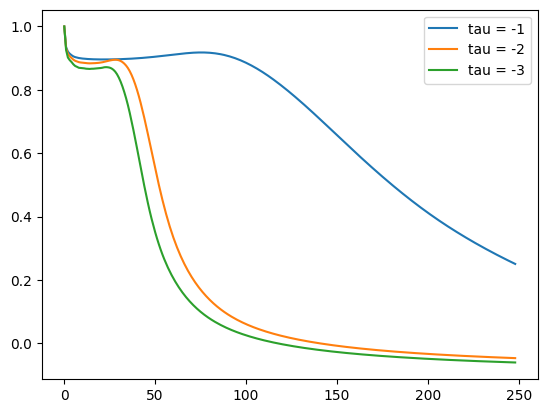

In [ ]:
####################################################### Hyperparameters and Sample

N=500
n=500
d=101
s_Y=1 # scale parameter of Pareto/Lomax distribution
c= 2 # c is \kappa the tail index of g
tau=-2 # tail index of \vfi
#nu = 1 #  tail index of \psi such that 2\gamma \nu_j < 1 for all 1\le j \le J
snr=10 # signal-to-noise ratio
H=1/3 # Hurst parameter of fBm noise
gamma=1/3# 1/3 or 1/2 or 9/10
rho=-1/2
mu = 200 # noise mean
l=2 # grid parameter
start = 4

tic=time.time()

#Y=Pareto_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
#Y=Lomax_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)
Y_sim=Y

Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)


#################################################### Correlation (concomittant) plot (Synthetic data)

m=int(n/2) # 1\le m \le n
tic=time.time()
A=concomittant_corr(X,Y,Y_sort_index,-1,m)[:,1:]
A2=concomittant_corr(X,Y,Y_sort_index,-2,m)[:,1:]
A3=concomittant_corr(X,Y,Y_sort_index,-3,m)[:,1:]
print("Time cost",time.time()-tic)

# Calculate the maximum and minimum values for each position

mean_values_A = np.nanmean(A, axis=0) # shape (int(n/l),)
#median_values_A = np.nanmedian(A, axis=0) # shape (int(n/l),)

mean_values_A2 = np.nanmean(A2, axis=0) # shape (int(n/l),)
#median_values_A2 = np.nanmedian(A2, axis=0) # shape (int(n/l),)

mean_values_A3 = np.nanmean(A3, axis=0) # shape (int(n/l),)
#median_values_A3 = np.nanmedian(A3, axis=0) # shape (int(n/l),)

# Create x values (assuming x values are just indices in this case)
x_values_A = np.arange(m-1)#np.arange(int(n/l))

fig,ax = plt.subplots()

# Set x-axis tick labels to discretized interval [1,250]
#ax.xaxis.set_major_locator(plt.MaxNLocator(27))
#ax.set_xticklabels([1, 1, 10 , 20, 30,  40, 50, 60, 70, 80, 90, 100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250])

# Plot the fill between the max and min values
#ax.fill_between(x_values_A, min_values_A, max_values_A, color='skyblue', alpha=0.4, label='Confidence Area')
ax.plot(x_values_A, mean_values_A, label='tau = -1')

#ax.fill_between(x_values_A, min_values_A2, max_values_A2, color='skyblue', alpha=0.4, label='Confidence Area')
ax.plot(x_values_A, mean_values_A2, label='tau = -2')

#ax.fill_between(x_values_A, min_values_A3, max_values_A3, color='skyblue', alpha=0.4, label='Confidence Area')
ax.plot(x_values_A, mean_values_A3, label='tau = -3')

# Add labels and legend
#ax.xlabel('Index')
#ax.ylabel('Values')
#ax.title('FEPLS Estimation of beta - Confidence intervals')
plt.legend()
plt.savefig('beta_estim_corr_2_0_333.pdf')
# Show the plot
plt.show()

In [ ]:
####################################################### Hyperparameters and Sample

N=500
n=500
d=101
s_Y=1 # scale parameter of Pareto/Lomax distribution
c= 1 # c is \kappa the tail index of g
tau=-2 # tail index of \vfi
#nu = 1 #  tail index of \psi such that 2\gamma \nu_j < 1 for all 1\le j \le J
snr=10 # signal-to-noise ratio
H=1/3 # Hurst parameter of fBm noise
gamma=1/3# 1/3 or 1/2 or 9/10
rho=-1/2
mu = 200 # noise mean
l=2 # grid parameter
start = 4

tic=time.time()

#Y=Pareto_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
#Y=Lomax_quantile_function(npr.uniform(0,1,size=(N,n)),theta,s_Y)
Y=Burr_quantile_function(npr.uniform(0,1,size=(N,n)),gamma,rho)
Y_sort_index = np.argsort(Y,axis=1)
Y_sim=Y

Z=npr.normal(0,1,size=(N,n,d - 1)) # latent variables for fBm sampling
aux=np.multiply.outer(Y**c,beta_func(d)) # g(Y)\beta
eps=coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu) 
X=aux+eps
Y_sort_index = np.argsort(Y,axis=1)
m=int(n/5)

####################################################### hatbeta_dot_beta (Synthetic Data)

l=2 # grid parameter
A=hatbeta_dot_beta(X,Y,-1,l)
A2=hatbeta_dot_beta(X,Y,-2,l)
A3=hatbeta_dot_beta(X,Y,-3,l)

print("Time cost",time.time()-tic)

# Calculate the maximum and minimum values for each position
mean_values_A = np.nanmean(A, axis=0) # shape (int(n/l),)
#median_values_A = np.nanmedian(A, axis=0) # shape (int(n/l),)

mean_values_A2 = np.nanmean(A2, axis=0) # shape (int(n/l),)
#median_values_A2 = np.nanmedian(A2, axis=0) # shape (int(n/l),)

mean_values_A3 = np.nanmean(A3, axis=0) # shape (int(n/l),)
#median_values_A3 = np.nanmedian(A3, axis=0) # shape (int(n/l),)

# Create x values (assuming x values are just indices in this case)
x_values_A = np.arange(int(n/l))

fig,ax = plt.subplots()

# Plot the fill between the max and min values
#ax.fill_between(x_values_A, min_values_A, max_values_A, color='skyblue', alpha=0.4, label='Confidence Area')
ax.plot(x_values_A, mean_values_A, label='tau = -2')

#ax.fill_between(x_values_A, min_values_A2, max_values_A2, color='skyblue', alpha=0.4, label='Confidence Area')
ax.plot(x_values_A, mean_values_A2, label='tau = -3')

#ax.fill_between(x_values_A, min_values_A3, max_values_A3, color='skyblue', alpha=0.4, label='Confidence Area')
ax.plot(x_values_A, mean_values_A3, label='tau = -4')

# Add labels and legend
#ax.xlabel('Index')
#ax.ylabel('Values')
#ax.title('FEPLS Estimation of beta - Confidence intervals')
plt.legend()
#plt.savefig('beta_estim_exceedance_1_5_0_9.pdf')
# Show the plot
plt.show()
